In [1]:
import numpy as np
from osgeo import gdal
import matplotlib.pyplot as plt
import glob
import re

In [2]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Conv2DTranspose, Conv1D, Conv3D, Conv3DTranspose
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Lambda, AlphaDropout
from keras.layers.advanced_activations import LeakyReLU
from keras.models import load_model, Model
# from keras.preprocessing.image import ImageDataGenerator
from keras.layers.merge import add, concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras import backend as K
import os, random

C:\Users\yuch\Downloads\anaconda3\envs\nz_convnet\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


define of class Data, TrainValTensorboard, myModel

In [3]:
class Data:
    
    def __init__(self, path, num=1000, random=False):
        """
        input:
            path: path to the block
            max_num: int, num of samples
            random: bool, to load samples randomly or from 0 to num_max
        """
        self.path_to_block = path
        self.N = num
        self.random = random
        
    def img_to_array(self, input_file, normalizer, dtype='float32'):
        """
        convert a raster tile into numpy array
        input:
            input_file: string, path a raster(.tif)
            normalizer: double, if input is labels with 0 or 1, it's 1.
                                if input is sentinal data (reflectance), then it's 10000.
            dtype: string, data type, default as 'float32'
        return:
            arr: numpy array, shape is [dim_y, dim_x, num_bands]
        """
        file = gdal.Open(input_file)
        bands = [np.array(file.GetRasterBand(i).ReadAsArray()).astype(dtype) / normalizer for i in range(1, file.RasterCount + 1)]
        arr = np.stack(bands, axis=2)
        return arr

    def load_XY(self):
        """
        function: load max_num of XY into lists
        output: list of numpy arrays, X (images) and Y (labels)
        """
        X_out = []
        Y_out = []
        X_path = sorted(glob.glob(self.path_to_block+"images/images/*.tif"))
        Y_path = sorted(glob.glob(self.path_to_block+"labels/images/*.tif"))
        if len(X_path) != len(Y_path):
            raise ValueError('imgs and labels are not matched')
        if self.random:
            idx = np.random.randint(0, len(X_path), self.N)
        else:
            idx = range(self.N)

        for i in idx:
            X_out.append(self.img_to_array(X_path[i], 10000.))
            Y_out.append(self.img_to_array(Y_path[i], 1.))
        return X_out, Y_out
        
    def trn_tst_split(self, test_rate, random_seed):
        """
        input:  test_rate, double, between 0 and 1,
                random_seed, randomness to generate tst and trn data
        output: lists of train and test datasets
        """
        X, Y = self.load_XY()
        X_trn, X_tst, Y_trn, Y_tst = train_test_split(X, Y, train_size=1-test_rate, test_size=test_rate, random_state=random_seed)
        return np.asarray(X_trn), np.asarray(X_tst), np.asarray(Y_trn), np.asarray(Y_tst)
    
class TrainValTensorBoard(TensorBoard):
    def __init__(self, log_dir='./logs', hist_freq=1, **kwargs):
        # Make the original `TensorBoard` log to a subdirectory 'training'
        training_log_dir = os.path.join(log_dir, 'training')
        super(TrainValTensorBoard, self).__init__(training_log_dir, histogram_freq=hist_freq, **kwargs)

        # Log the validation metrics to a separate subdirectory
        self.val_log_dir = os.path.join(log_dir, 'validation')

    def set_model(self, model):
        # Setup writer for validation metrics
        self.val_writer = tf.summary.FileWriter(self.val_log_dir)
        super(TrainValTensorBoard, self).set_model(model)

    def on_epoch_end(self, epoch, logs=None):
        # Pop the validation logs and handle them separately with
        # `self.val_writer`. Also rename the keys so that they can
        # be plotted on the same figure with the training metrics
        logs = logs or {}
        val_logs = {k.replace('val_', ''): v for k, v in logs.items() if k.startswith('val_')}
        for name, value in val_logs.items():
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.val_writer.add_summary(summary, epoch)
        self.val_writer.flush()

        # Pass the remaining logs to `TensorBoard.on_epoch_end`
        logs = {k: v for k, v in logs.items() if not k.startswith('val_')}
        super(TrainValTensorBoard, self).on_epoch_end(epoch, logs)

    def on_train_end(self, logs=None):
        super(TrainValTensorBoard, self).on_train_end(logs)
        self.val_writer.close()

In [4]:
class myModel:
    
    def __init__(self):
        self.model = None
        self.callbackList = None
        self.model_type = None
        self.init_epoch = 0
        return
        
    def build_Conv1D(self, num_bands=9, dim_width=256, dim_height=256,
                     num_filters=64, len_filter=1, num_labels=10):
        self.model_type = 'Conv1D'
        return
    
    def build_Conv3D(self):
        self.model_type = 'Conv3D'
        return

    def build_Conv2D(self, num_bands=9, dim_width=256, dim_height=256, n_ch_list=[64, 64],
                     num_labels=10, k_init='lecun_normal', activation='selu', use_tfboard=False):
        """
        input:
            num_bands, int, number of input channels
            n_ch_list, list, int numbers for num of channels of each layer
            num_labels, int, num of classes that each pixel will be assigned a prob, should be filters of last 'softmax' layer
            k_init, string, define the way of initializing the weights
            activation, string, define the activation function of intermediate layers
        output:
            keras model
        """

        if K.image_data_format() == 'channels_first':
            ch_axis = 1
            input_shape = (num_bands, dim_width, dim_height)
        elif K.image_data_format() == 'channels_last':
            ch_axis = 3
            input_shape = (dim_width, dim_height, num_bands)


        inp = Input(input_shape)
        encoder = inp
        list_encoders = []

    # summary image requires num of channels to be 1, 3 or 4
    #     if use_tfboard:
    #         tf.summary.image(name='input', tensor=inp)  

        print('building Conv2D ...')
        print(n_ch_list)
        k_size = (3, 3)
        # encoders
        for l_idx, n_ch in enumerate(n_ch_list):
            with K.name_scope('Encoder_block_{0}'.format(l_idx)):
                encoder = Conv2D(filters=n_ch, kernel_size=k_size, activation=activation, padding='same',
                                 kernel_initializer=k_init)(encoder)
                encoder = AlphaDropout(0.1*l_idx, )(encoder)
                encoder = Conv2D(filters=n_ch, kernel_size=k_size, dilation_rate=(2, 2),
                                 activation=activation, padding='same', kernel_initializer=k_init)(encoder)
                list_encoders.append(encoder)
                # add maxpooling layer except the last layer
                if l_idx < len(n_ch_list) - 1:
                    encoder = MaxPooling2D(pool_size=(2,2))(encoder)
                if use_tfboard:
                    tf.summary.histogram('conv_encoder', encoder)
        # decoders
        decoder = encoder
        dec_n_ch_list = n_ch_list[::-1][1:]
        print(dec_n_ch_list)
        for l_idx, n_ch in enumerate(dec_n_ch_list):
            with K.name_scope('Decoder_block_{0}'.format(l_idx)):
                l_idx_rev = len(n_ch_list) - 1 - l_idx
                decoder = concatenate([decoder, list_encoders[l_idx_rev]], axis=ch_axis)
                decoder = Conv2D(filters=n_ch, kernel_size=k_size, activation=activation, padding='same',
                                 dilation_rate=(2, 2), kernel_initializer=k_init)(decoder)
                decoder = AlphaDropout(0.1*l_idx, )(decoder)
                decoder = Conv2D(filters=n_ch, kernel_size=k_size, activation=activation, padding='same',
                                 kernel_initializer=k_init)(decoder)
                decoder = Conv2DTranspose(filters=n_ch, kernel_size=k_size, strides=(2, 2), 
                                          activation=activation, padding='same', kernel_initializer=k_init)(decoder)

        # output layer should be softmax
        # instead of using Conv2DTranspose, Dense layer could also be tried
        outp = Conv2DTranspose(filters=num_labels, kernel_size=k_size, activation='softmax',
                               padding='same', kernel_initializer='glorot_normal')(decoder)

        # summary image requires num of channels to be 1, 3 or 4
    #         if use_tfboard:
    #             tf.summary.image(name='output', tensor=outp)

        self.model = Model(inputs=[inp], outputs=[outp])
        
        self.model_type = 'Conv2D'
        return
    
    def compile_model(self, loss='categorical_crossentropy', lr=1e-3, verbose=True):
        """
        input:
                loss: string
                lr: double
                verbose: bool
        """
        if self.model_type == None:
            raise ValueError('model is not built yet, please build 1D, 2D or 3D convnet model')
            
        print('compiling model ...')
        
        # specify loss and optimizer
        loss = 'categorical_crossentropy'
        adam = keras.optimizers.adam(lr=lr)

        # build the whole computational graph with model, loss and optimizer
        self.model.compile(loss=loss, optimizer=adam, metrics=['accuracy'])

        # print parameters of each layer
        if verbose:
            print(self.model.summary())
        return
    
    def build_callbackList(self, log_dir='./logs'):
        
        if self.model_type == None:
            raise ValueError('model is not built yet, please build 1D, 2D or 3D convnet model')
        else:
            path = './{0}'.format(self.model_type)
            
        # Tensorboard
        tensorboard = TrainValTensorBoard(log_dir=log_dir)

        # Model Checkpoints
        if not os.path.exists(path):
            os.makedirs(path)
        filepath=path+'/weights-{epoch:02d}-{val_acc:.2f}.hdf5'
        checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='max')

        # Bring all the callbacks together into a python list
        self.callbackList = [tensorboard, checkpoint]
        return
        
    def load_checkpoint(self):

        if self.model_type == None:
            raise ValueError('model is not built yet, please build 1D, 2D or 3D convnet model')
        else:
            path = './{0}'.format(self.model_type)
        try:
            checkfile = sorted(glob.glob(path+"/weights-*-*.hdf5"))[-1]
            self.model.load_weights(checkfile)
            self.init_epoch = int(re.search(r"weights-(\d*)-", checkfile).group(1))
            print("{0} weights loaded, resuming from epoch {1}".format(self.model_type, self.init_epoch))
        except IndexError:
            try:
                self.model.load_weights(path+"/model-weights.hdf5")
                print("{0} weights loaded, starting from epoch {1}".format(self.model_type, self.init_epoch))
            except OSError:
                pass
        return

    def fit_model(self, X_trn, Y_trn, verbose=1, validation_split=0.2, batch_size=6, epochs=10):
        self.model.fit(x=X_trn, y=Y_trn, verbose=verbose, validation_split=validation_split, 
                       batch_size=batch_size, epochs=epochs,
                       callbacks=self.callbackList, initial_epoch=self.init_epoch)
        return

    def save_weights(self, suffix='model-1'):

        if self.model_type == None:
            raise ValueError('model is not built yet, please build 1D, 2D or 3D convnet model')
        else:
            path = './{0}'.format(self.model_type)

        filepath = path+'/{0}.hdf5'.format(suffix)
        self.model.save_weights(filepath=filepath)
        return
        
    def load_weights(self, filepath):

        if self.model_type == None:
            raise ValueError('model is not built yet, please build 1D, 2D or 3D convnet model')

        self.model.load_weights(filepath=filepath)
        return
        
    def predict(self, X_tst, verbose=1):
        
        return self.model.predict(X_tst, verbose=verbose)

load 100 X-Y samples from block1, and split into train and test sets

In [5]:
data = Data('./data/block1/', num=100)
X_trn, X_tst, Y_trn, Y_tst = data.trn_tst_split(test_rate=0.1, random_seed=42)

visualize images and labels

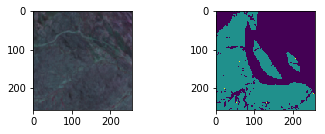

In [39]:
idx = 10
rock_class = 7

img = X_trn[idx,:,:,:]
lbl = Y_trn[idx,:,:,:]

img_rgb = img[:, :, ::-1][:, :, :3]
plt.subplot(221)
plt.imshow(img_rgb)
plt.subplot(222)
plt.imshow(lbl[:,:,rock_class])

start to build and train Conv2D

In [40]:
conv = myModel()

# build Conv2D
conv.build_Conv2D(use_tfboard=True)

# now the tensorboard event file is saved in ./logs
# the training process, graph and statistics can be
# visualize by tensorboard

# compile with loss and optimizer
conv.compile_model(verbose=False)

# build callback for the details of train process
conv.build_callbackList()

building Conv2D ...
[64, 64]
[64]
compiling model ...


In [44]:
from keras.models import Sequential
from keras.layers import Convolution1D

In [56]:
nb_features = 12
nb_class = 9
model = Sequential()
model.add(Convolution1D(nb_filter=512, filter_length=2, input_shape=(nb_features, 1)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(2048, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(nb_class))
model.add(Activation('softmax'))

C:\Users\yuch\Downloads\anaconda3\envs\nz_convnet\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(input_shape=(12, 1), filters=512, kernel_size=2)`
  after removing the cwd from sys.path.


In [57]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam' ,metrics=['accuracy'], verbose=True)

In [58]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 11, 512)           1536      
_________________________________________________________________
activation_6 (Activation)    (None, 11, 512)           0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 5632)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 5632)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 2048)              11536384  
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_11 (Dense)             (None, 9)                 9225      
__________

In [13]:
# start to training
conv.fit_model(X_trn=X_trn, Y_trn=Y_trn, epochs=10, verbose=1)

Train on 72 samples, validate on 18 samples
Epoch 1/10
72/72 [==============================] - 127s 2s/step - loss: 0.6729 - acc: 0.1132 - val_loss: 0.8732 - val_acc: 0.0722

Epoch 00001: val_acc improved from -inf to 0.07224, saving model to ./Conv2D/weights-01-0.07.hdf5
Epoch 2/10
72/72 [==============================] - 131s 2s/step - loss: 0.6394 - acc: 0.1049 - val_loss: 0.6121 - val_acc: 0.0898

Epoch 00002: val_acc improved from 0.07224 to 0.08982, saving model to ./Conv2D/weights-02-0.09.hdf5
Epoch 3/10
72/72 [==============================] - 132s 2s/step - loss: 0.5943 - acc: 0.1260 - val_loss: 0.6281 - val_acc: 0.0676

Epoch 00003: val_acc did not improve
Epoch 4/10
72/72 [==============================] - 129s 2s/step - loss: 0.5513 - acc: 0.1674 - val_loss: 0.6632 - val_acc: 0.1054

Epoch 00004: val_acc improved from 0.08982 to 0.10542, saving model to ./Conv2D/weights-04-0.11.hdf5
Epoch 5/10
72/72 [==============================] - 125s 2s/step - loss: 0.6139 - acc: 0.10

predict on test data

In [14]:
# conv.save_weights()
# conv.load_weights('./Conv2D/model-1.hdf5')

In [15]:
Y_preds = conv.predict(X_tst=X_tst)

10/10 [==============================] - 5s 544ms/step


visualize predicted Y

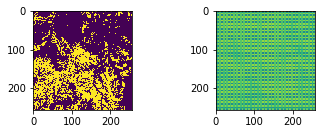

In [36]:
idx = 4
n_class = 5
plt.subplot(221)
plt.imshow(Y_tst[idx,:,:,n_class])
plt.subplot(222)
plt.imshow(Y_preds[idx,:,:,n_class])

In [41]:
np.histogram(np.argmax(Y_preds[idx,:,:,:], axis=2))

(array([  386,     0, 65000,     0,     0,     0,     0,   123,     0,
           27], dtype=int64),
 array([4. , 4.4, 4.8, 5.2, 5.6, 6. , 6.4, 6.8, 7.2, 7.6, 8. ]))